In [1]:
import numpy as np
from PIL import Image
import json
import os
import copy
import argparse
from tqdm import tqdm
import notebook_mesh_utils as nu

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from tomo2mesh.projects.steel_am.coarse2fine import coarse_map, process_subset
from tomo2mesh.misc.voxel_processing import TimerGPU
from tomo2mesh.structures.voids import Voids
from tomo2mesh.porosity.params_3dunet import *
from tomo2mesh.unet3d.surface_segmenter import SurfaceSegmenter
from tomo2mesh.fbp.recon import recon_slice, recon_binned, recon_all

import cupy as cp
import tomo2mesh.fbp.subset as subset
import cupyx.scipy as cpsp
import tomo2mesh.misc.voxel_processing as vp
import skimage.filters as filters
import scipy as sp
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
metadata_fp = '/home/beams/S1IDUSER/mnt/orthros/faber_mar21_data/faber_mar21/metadata/faber_mar21/faber_sam1_s12_crack_tomo/faber_sam1_s12_crack_tomo_TomoFastScan.dat'
override_path = '/home/beams/S1IDUSER/mnt/orthros/faber_mar21_data/faber_mar21/tomo/faber_sam1_s12_crack_tomo'

scans = nu.extract_scan_data(metadata_fp, override_path)

In [3]:
nu.print_avail_scans(scans)

[0]: [173994, 175794]
[1]: [173994, 175794]
[2]: [173994, 175794]
[3]: [173994, 175794]
[4]: [173994, 175794]
[5]: [173994, 175794]
[6]: [173994, 175794]
[7]: [173994, 175794]
[8]: [173994, 175794]
[9]: [173994, 175794]
[10]: [173994, 175794]
[11]: [173994, 175794]
[12]: [173994, 175794]
[13]: [173994, 175794]
[14]: [173994, 175794]
[15]: [173994, 175794]
[16]: [173994, 175794]
[17]: [173994, 175794]
[18]: [173994, 175794]
[19]: [173994, 175794]
[20]: [173994, 175794]
[21]: [173994, 175794]
[22]: [173994, 175794]


In [4]:
selected_scan = 5

scan = scans[selected_scan]
projs = nu.load_images(scan)

Loading Imgs: 100%|██████████| 1801/1801 [00:44<00:00, 40.62it/s] 


In [5]:
center = projs.shape[-1]/2.0 # assuming that object is perfectly centered
print('Assuming object is perfectly centered...')

Assuming object is perfectly centered...


In [6]:
pixel_ds = 2
scan_ds = 2
num_gpu_batches = 5

In [11]:
recon = nu.reconstruct(
    projs=projs,
    omega=scan.omega,
    center=center,
    pixel_ds=pixel_ds,
    scan_ds=scan_ds,
    num_gpu_batches=num_gpu_batches
)
recon_original = copy.deepcopy(recon)

100%|██████████| 120/120 [00:05<00:00, 20.82it/s]


In [10]:
print(recon.shape)
print(type(recon))

(600, 960, 960)
<class 'numpy.ndarray'>


In [12]:
# Insert reconstruction pipeline here
recon[:] = sp.ndimage.gaussian_filter(recon, 0.5)

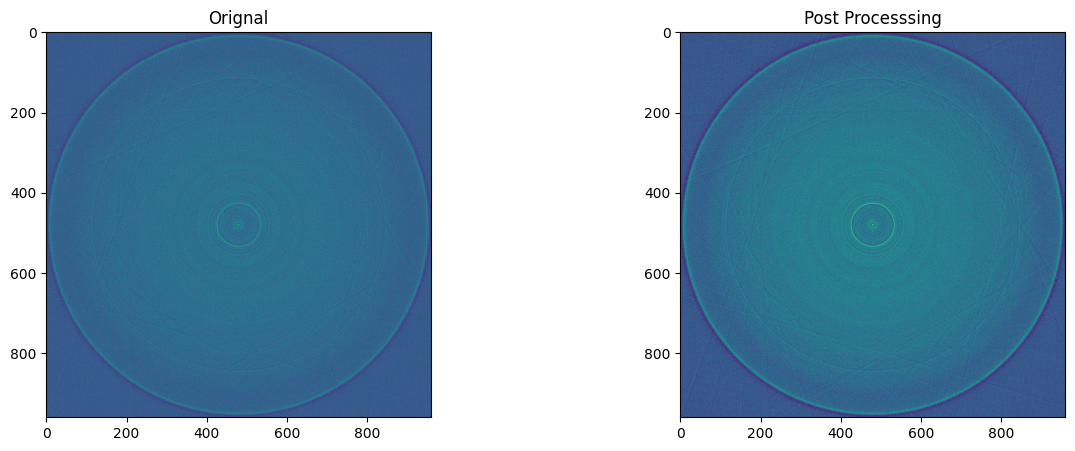

In [14]:
im_layer = 500

_ = nu.plot_recon_compare(recon_original, recon, im_layer)

In [ ]:
V_np_2 = cp.asnumpy(V)

In [ ]:
V[:] = cpsp.ndimage.gaussian_filter(V,0.5)

# binarize
voxel_values = vp.get_values_cyl_mask(V[::2,::2,::2], 1.0).get()
rec_min_max = vp.modified_autocontrast(voxel_values, s=0.01)
thresh = cp.float32(filters.threshold_otsu(voxel_values))    
V[:] = (V<thresh).astype(cp.uint8)
vp.cylindrical_mask(V,0.95,1)

# connected components labeling
V = cp.array(V, dtype = cp.uint32)
V[:], n_det = cpsp.ndimage.label(V,structure = cp.ones((3,3,3),dtype=cp.uint8))    

dust_thresh = 2

voids_b = Voids().count_voids(V.get(), b, dust_thresh, pad_bb = 2)    

voids_b["rec_min_max"] = rec_min_max


In [ ]:
del V
memory_pool.free_all_blocks()    